In [3]:
import os
os.chdir("/content/drive/MyDrive/Colab/tensorflow_&_pytorch_classifier")


number of classes in processed dataset=  6
the maximum files in any class in train_df is  215   the minimum files in any class in train_df is  89
train_df length:  801   test_df length:  101   valid_df length:  100
the are 9 bad image files and 1002 proper image files in the dataset
datasets_of_food/burgers /2023_11_19_15_51_IMG_2734.GIF
datasets_of_food/burgers /2023_11_19_15_51_IMG_2735.GIF
datasets_of_food/friedchicks/1372001-5689f96c13584785ae8571e0659b936b.webp
datasets_of_food/friedchicks/24087-Resturant-StyleBuffaloChickenRings-mfs-Step-3-06bc62423dc24f6a8a39bd25c03f1787.webp
datasets_of_food/friedchicks/24087-restaurant-style-buffalo-chicken-wings-DDMFS-4x3-861e36c713264f3a9db8ba02d3afbea1.webp
datasets_of_food/friedchicks/49734625-4349-b__1688-768x432.webp
datasets_of_food/friedchicks/AR_GC_ChickenWings_stills_DSC03650-2000-12be251587604539949628bcf7170bad.webp
datasets_of_food/hot dog/2023_11_19_17_27_IMG_2861.GIF
datasets_of_food/thepizza/medium_d9646f80-5041-4b31-8757-127d

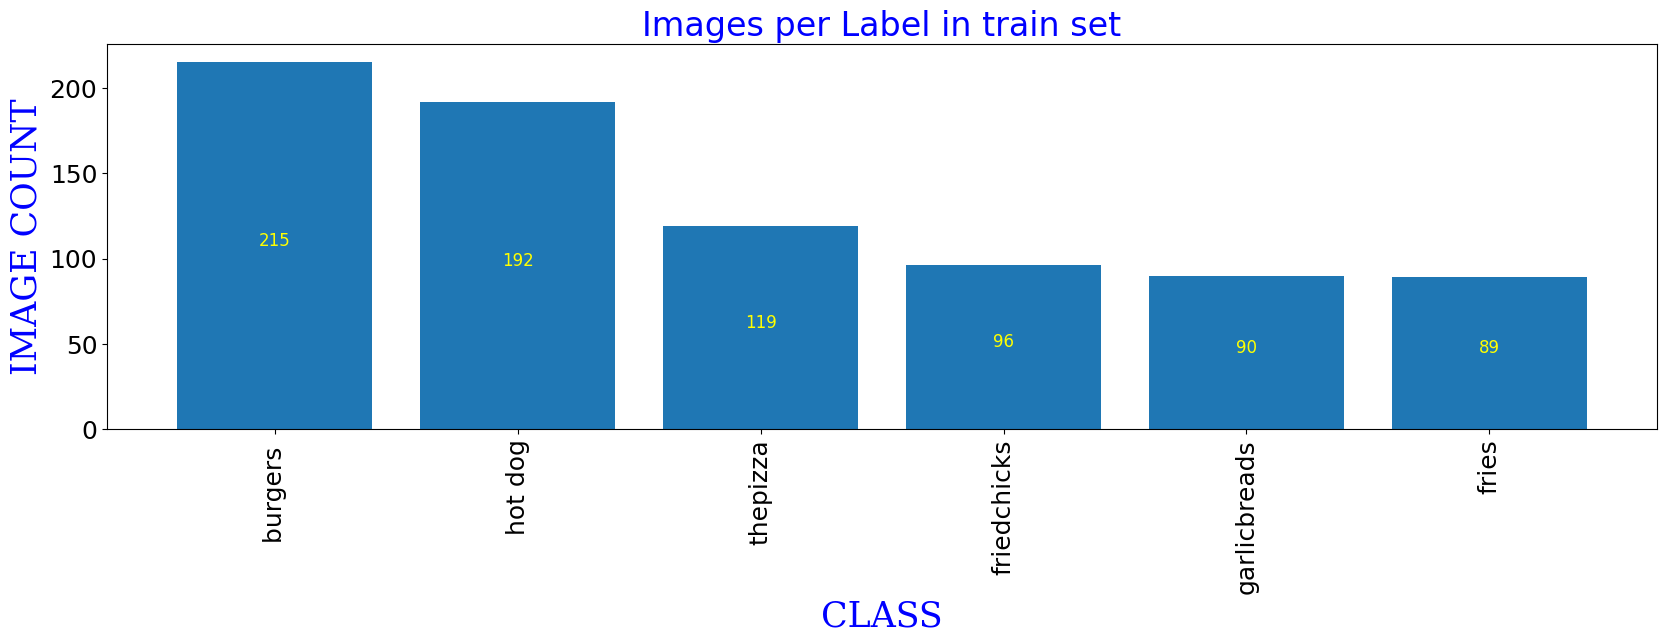

In [4]:
from customizing import Customize
import os
import pandas as pd
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
train_dir = "datasets_of_food"
cusomize = Customize(framework='pytorch')
ftotal, flargest, maxclass, fsmallest, minclass = cusomize.check_dataset_size(train_dir)
train_df, test_df, valid_df, classes, class_count, max_samples, min_samples, have, wave = cusomize.make_data_frames(train_dir , None , None , None)

In [5]:
from pandas.core.common import flatten

def image_path_to_flatten(data_frame):
    image_path = []
    for data_path in data_frame['filepaths']:
        image_path.append(data_path)
        image_path = list(flatten(image_path))
    return image_path

In [6]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [8]:
##### from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
class LandmarkDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label

#######################################################
#                  Create Dataset
#######################################################

train_dataset = LandmarkDataset(image_path_to_flatten(train_df),train_transforms)
valid_dataset = LandmarkDataset(image_path_to_flatten(valid_df),test_transforms) #test transforms are applied
test_dataset = LandmarkDataset(image_path_to_flatten(test_df),test_transforms)


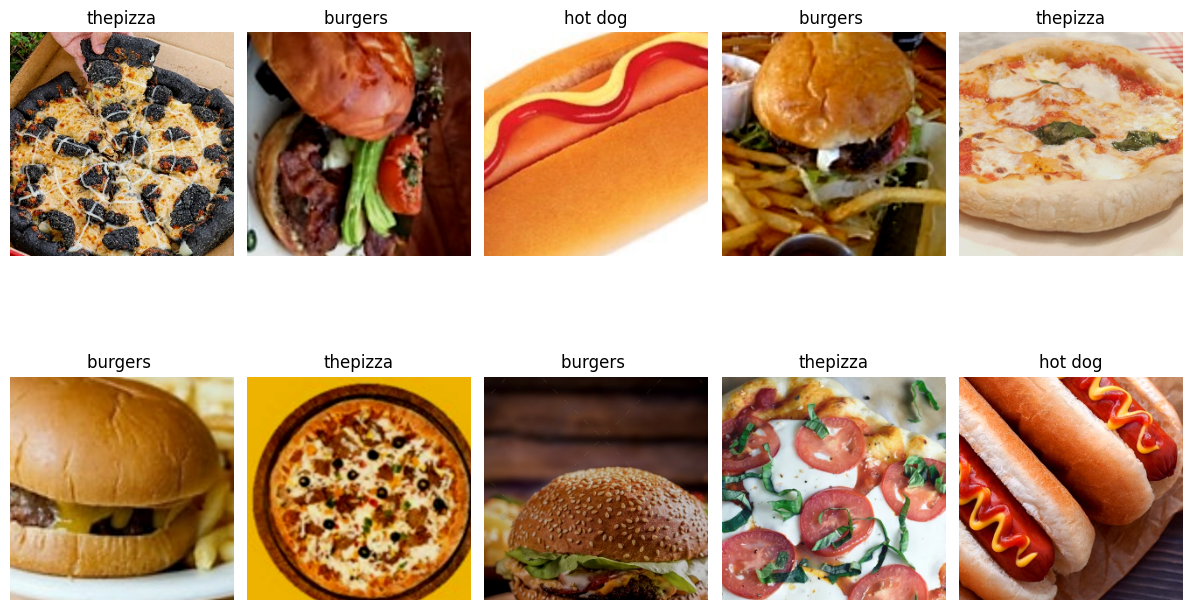

In [9]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import numpy as np
#######################################################
#                  Visualize Dataset
#         Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):

    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols


    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_df['filepaths']))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()

visualize_augmentations(train_dataset,np.random.randint(1,len(image_path_to_flatten(train_df))), random_img = True)

In [10]:
from torch.utils.data import DataLoader


#######################################################
#                  Define Dataloaders
#######################################################

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False
)

In [11]:
next(iter(train_loader))[0].shape

torch.Size([64, 3, 256, 256])

In [12]:
next(iter(train_loader))[1].shape

torch.Size([64])

In [13]:
####################################################
#                Define parameters
####################################################

params = {
#    "model": "resnet50",
    #"device": "cuda",
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 20,
    "n_epochs": 20,
    "image_size": 256,
    "in_channels": 3,
    "num_classes": 50
}

In [14]:
# useful variable that tells us whether we should use the GPU
import  torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [15]:
from torchvision import datasets, transforms, models
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s]


In [16]:
import torch.nn.functional as F
from torch import nn
from torch import optim
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm

In [17]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [18]:
def Net(num_classes):
    model = models.resnet50(pretrained=True)
    #model = EfficientNet.from_pretrained('efficientnet-b0')
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(2048, 1024)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(1024, 256)),
                              ('relu', nn.ReLU()),
                              ('fc3', nn.Linear(256, num_classes)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.fc = classifier
    return model

model = Net(params['num_classes'])
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader):
    #put model in training state
    model.train()

    train_loss = 0.0

    #pbar = tqdm(enumerate(train_loader), total = len(train_loader))
    #for step, (imgs, labels) in pbar:

    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        loss = loss_fn(preds, labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        train_loss+= ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        #if batch_idx%5==0:
        #    print('train loss', train_loss)

    print('Epoch {} avg Training loss: {:.3f}'.format(epoch+1, train_loss))

    return model, train_loss

def test_one_epoch(epoch, model, loss_fn, loader, img_paths):
    model.eval()

    #pbar = tqdm(enumerate(test_loader), total = len(test_loader))
    running_loss = 0
    actual_labels = []
    pred_labels = []

    #for step, (imgs, labels) in pbar:
    for batch_idx, (imgs, labels) in enumerate(loader):
        imgs, labels = imgs.to(device), labels.to(device)
        log_preds = model(imgs)
        loss = loss_fn(log_preds, labels)


        preds = torch.exp(log_preds)
        running_loss+=((1 / (batch_idx + 1)) * (loss.data.item() - running_loss))

        #calculate accuracy
        top_prob, top_class = preds.topk(1, dim=1)
        pred_labels+= list((top_class.view(-1)).cpu().numpy())
        actual_labels+= list(labels.cpu().numpy())



    accuracy = ((np.array(pred_labels)==np.array(actual_labels)).sum())/len(img_paths) #size of test set
    correct = ((np.array(pred_labels)==np.array(actual_labels)).sum())
    total = len(img_paths)


    return running_loss, accuracy, correct, total

In [20]:
from torch import optim

loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = params['lr'])

In [21]:
train_losses = []
valid_losses = []

for epoch in range(params["n_epochs"]):
    train_loss = train_one_epoch(epoch, model, loss_fn, optimizer, train_loader)
    train_losses+= [train_loss]


    valid_loss, accuracy, correct, total = test_one_epoch(epoch, model, loss_fn, valid_loader, image_path_to_flatten(valid_df))
    valid_losses+=[valid_loss]

    print('Epoch {} avg Valid loss: {:.3f}'.format(epoch+1, valid_loss))
    print('Epoch {} Valid accuracy: {:.1%} ({} of {} right)\n'.format(epoch+1, accuracy, correct, total))

    if len(valid_losses)>1 and (valid_loss<min(valid_losses[:-1])):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            'train_transforms': train_transforms,
            'test_transforms': test_transforms,
            }, 'checkpoint.tar')


Epoch 1 avg Training loss: 2.275
Epoch 1 avg Valid loss: 1.601
Epoch 1 Valid accuracy: 39.0% (39 of 100 right)

Epoch 2 avg Training loss: 1.399
Epoch 2 avg Valid loss: 0.899
Epoch 2 Valid accuracy: 80.0% (80 of 100 right)

Epoch 3 avg Training loss: 0.951
Epoch 3 avg Valid loss: 0.496
Epoch 3 Valid accuracy: 86.0% (86 of 100 right)

Epoch 4 avg Training loss: 0.736
Epoch 4 avg Valid loss: 0.584
Epoch 4 Valid accuracy: 77.0% (77 of 100 right)

Epoch 5 avg Training loss: 0.730
Epoch 5 avg Valid loss: 0.291
Epoch 5 Valid accuracy: 91.0% (91 of 100 right)

Epoch 6 avg Training loss: 0.687
Epoch 6 avg Valid loss: 0.354
Epoch 6 Valid accuracy: 88.0% (88 of 100 right)

Epoch 7 avg Training loss: 0.543
Epoch 7 avg Valid loss: 0.247
Epoch 7 Valid accuracy: 93.0% (93 of 100 right)

Epoch 8 avg Training loss: 0.548
Epoch 8 avg Valid loss: 0.267
Epoch 8 Valid accuracy: 93.0% (93 of 100 right)

Epoch 9 avg Training loss: 0.521
Epoch 9 avg Valid loss: 0.184
Epoch 9 Valid accuracy: 95.0% (95 of 100 

In [22]:
# load the model that got the best validation accuracy
checkpoint = torch.load('checkpoint.tar')
loaded_model = Net(params['num_classes'])
loaded_model.to(device)
loaded_model.load_state_dict(checkpoint['model_state_dict'])

loaded_criterion = checkpoint['loss']

#optimizer = optim.Adam(model.parameters(), lr = 0.003)
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

last_epoch = checkpoint['epoch']+1

test_loss, accuracy, correct, total = test_one_epoch(None, loaded_model, loaded_criterion, test_loader, image_path_to_flatten(test_df))

print('Test loss: {:.3f}'.format(test_loss))
print('Test accuracy: {:.1%} ({} of {} right)\n'.format(accuracy, correct, total))

Test loss: 0.161
Test accuracy: 96.0% (97 of 101 right)



In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Assuming you have a PyTorch model, criterion, and a DataLoader for evaluation
model.eval()
all_labels = []
all_predictions = []
model = model.to(device)
with torch.no_grad():
    for inputs, labels in test_loader:  # Replace eval_dataloader with your DataLoader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

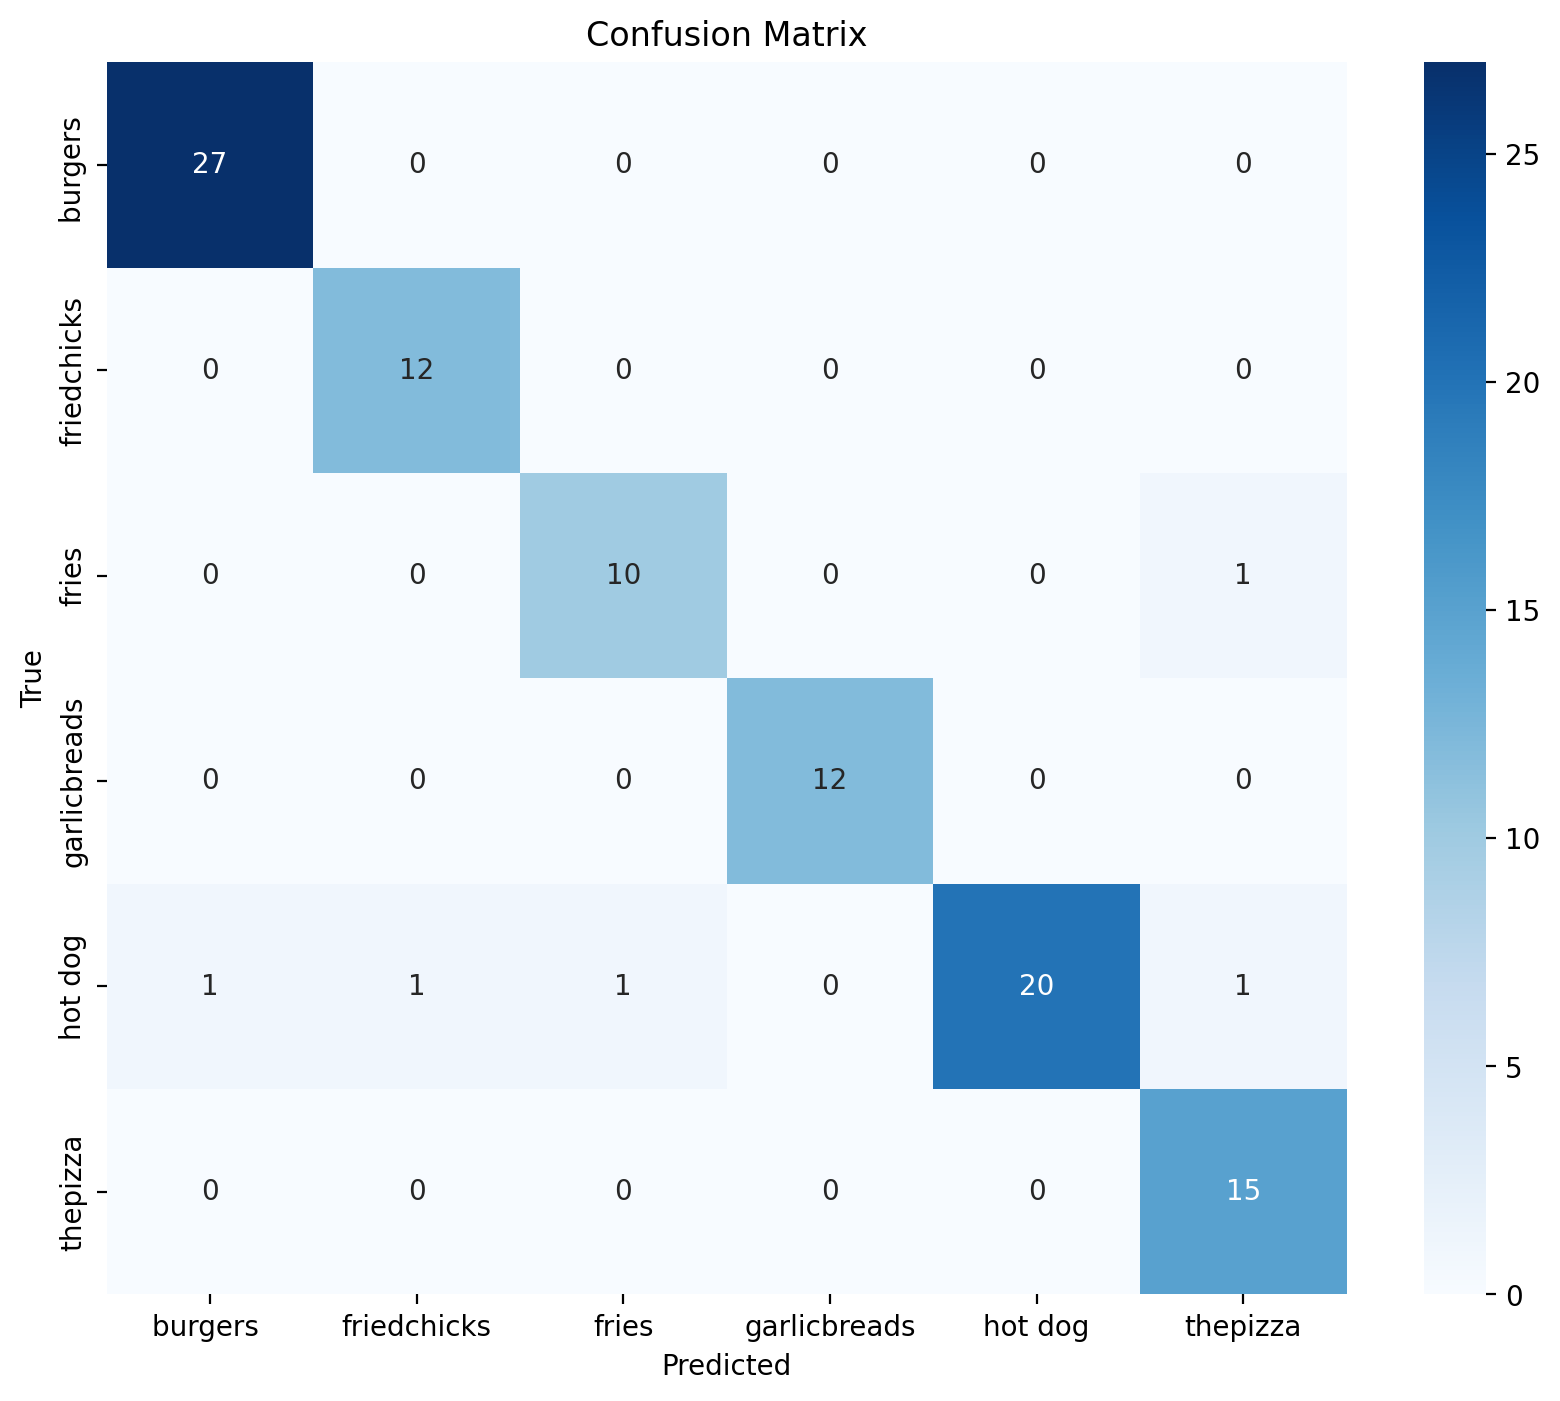

Classification Report:
               precision    recall  f1-score   support

    burgers        0.96      1.00      0.98        27
 friedchicks       0.92      1.00      0.96        12
       fries       0.91      0.91      0.91        11
garlicbreads       1.00      1.00      1.00        12
     hot dog       1.00      0.83      0.91        24
    thepizza       0.88      1.00      0.94        15

    accuracy                           0.95       101
   macro avg       0.95      0.96      0.95       101
weighted avg       0.95      0.95      0.95       101



In [37]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print classification report
print("Classification Report:\n", classification_report(all_labels, all_predictions, target_names=classes))

In [49]:
from sklearn.metrics import f1_score

all_labels_test = []
all_predictions_test = []
model = model.to(device)
with torch.no_grad():
    for inputs, labels in test_loader:  # Replace eval_dataloader with your DataLoader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels_test.extend(labels.cpu().numpy())
        all_predictions_test.extend(predicted.cpu().numpy())

# Calculate F1-score on test set
test_f1 = f1_score(all_labels_test, all_predictions_test, average='weighted')
print(f'Test F1-score: {test_f1:.4f}')

Test F1-score: 0.9496


In [48]:
all_labels_valid = []
all_predictions_valid = []
model = model.to(device)
model.eval()

with torch.no_grad():
    for inputs, labels in valid_loader:  # Replace eval_dataloader with your DataLoader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels_valid.extend(labels.cpu().numpy())
        all_predictions_valid.extend(predicted.cpu().numpy())

# Calculate F1-score on test set
test_f1 = f1_score(all_labels_valid, all_predictions_valid, average='weighted')
print(f'Test F1-score: {test_f1:.4f}')

Test F1-score: 0.9501
